# ASL Alphabet Classifier Test #2 - MobileNet_V2 version

#### Datasource: 
<a href="https://www.kaggle.com/grassknoted/asl-alphabet">https://www.kaggle.com/grassknoted/asl-alphabet</a>

<br>

This is a prototype, playing with FastAI using MobileNetV2 to classify American Sign Language alphabet.  It's basically Notebook #2 from the MOOC on a "clean" dataset.  We get great results ... but the data is really contrived.  It's highly likely the model will be overfitted, however it's a good test of the library.
<br>
<br>
<br>

In [1]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *
from fastai.vision import *
import fastai
import torchvision

# plt.style.use('dark')


In [2]:
path = '../data/external/Training Set'

<br>

### Create the DataBlock

In [3]:
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label)

# learn_inf = load_learner('../models/export-resnet101-tune10un-tune2ft.pkl')



<br>

## Resize and add basic image augmentation

In [4]:
# signs = signs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
# signs = signs.new(item_tfms=Resize(300, method=ResizeMethod.Squish))

# using a smaller frame because MobileNetV2 takes a lot of RAM
signs = signs.new(item_tfms=Resize(200, method=ResizeMethod.Squish))


# signs.apply_tfms(Image.flip)


<br>

### Load the data by path

In [5]:
dls = signs.dataloaders(path)


<br>

### Verify the Training and Validation Batches

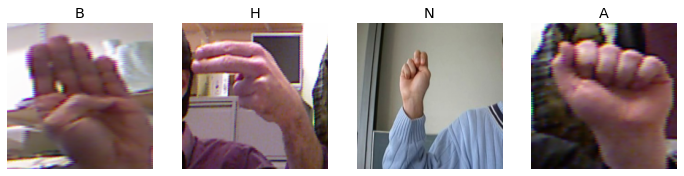

In [6]:
dls.train.show_batch(max_n=4, nrows=1)

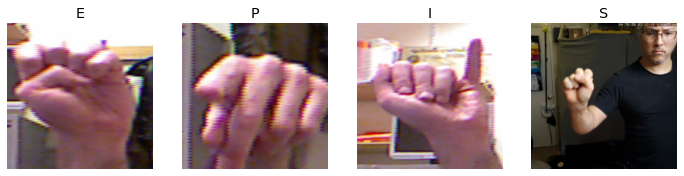

In [7]:
dls.valid.show_batch(max_n=4, nrows=1)

<br>

### Define the model (MobileNet_V2) and fit

In [8]:
mobilenet_split = lambda m: (m[0][0][10], m[1])
learn = cnn_learner(dls, torchvision.models.mobilenet_v2, split_on=mobilenet_split, cut=-1, metrics=error_rate)

<br>
<br>
<br>

## Manually find a learning rate between the shoulder and the steepest drop.

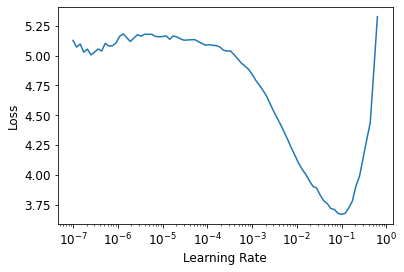

In [9]:
lr_min,lr_steep = learn.lr_find()


In [10]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 6.31e-03


<br>
<br>
<br>

## Fit the last layer to our data

In [ ]:
learn.fit_one_cycle(2, 4e-2)

In [11]:
learn.fine_tune(6, freeze_epochs=3, base_lr=8e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.375232,0.195417,0.062421,01:55
1,0.243778,0.103157,0.030178,01:54
2,0.165272,0.064574,0.017895,01:58


epoch,train_loss,valid_loss,error_rate,time
0,0.042610,0.024941,0.007042,02:48
1,0.041745,0.026111,0.007094,02:43
2,0.027714,0.012201,0.003124,02:47
3,0.009764,0.012390,0.002700,02:49
4,0.003823,0.009395,0.001959,02:46
5,0.001294,0.008081,0.001588,02:42


<br>
<br>
<br>

## Unfreeze the rest of the layers and find a new learning rate for the whole net.

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

<br>
<br>
<br>

## Fit the whole network at an appropriate learning rate

In [ ]:
learn.fit_one_cycle(2, lr_max=5e-5)

In [ ]:
learn.recorder.plot_loss()

<br>

### Visualize with a confusion Matrix

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

/home/frank/miniconda3/envs/learn/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


TypeError: __init__() missing 1 required positional argument: 'losses'

<br>

### Show the top 5 most error prone images

In [20]:
interp.plot_top_losses(15, nrows=3)

NameError: name 'interp' is not defined

<br>

### Clean the images that were hard to interpret and obviously bad

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner

ValueError: not enough values to unpack (expected 5, got 4)

<br>
<br>
<hr>
<br>
<br>

## Persist the Model

<br>
<br>

In [17]:
import dill

In [18]:
# version 1 regular
torch.save(learn.model, '../models/200923-2300-MOBILENET2-PYTORCHONLY-FALL-ft6f3.pt')

# version 2 dill
torch.save(learn.model, '../models/200923-2300-MOBILENET2-PYTORCHONLY-FALL-ft6f3-DILL.pt', pickle_module=dill)


In [26]:
learn.model.save('../models/200923-2300-MOBILENET2-PYTORCHONLY-FALL-ft6f3.pkl')
path = Path('../models')
path.ls(file_exts='.pkl')

ModuleAttributeError: 'Sequential' object has no attribute 'save'

In [33]:
%cd Sign1
%cd notebooks

[Errno 2] No such file or directory: 'Sign1'
/home/frank/Insync/cogsci2@gmail.com/Google Drive/Study Notes/Personal Repos/Sign1
/home/frank/Insync/cogsci2@gmail.com/Google Drive/Study Notes/Personal Repos/Sign1/notebooks


In [34]:
%cd ..
learn.save('save/200923-2300-MOBILENET2-PYTORCHONLY-FALL-ft6f3.pth')
%cd notebooks

/home/frank/Insync/cogsci2@gmail.com/Google Drive/Study Notes/Personal Repos/Sign1
/home/frank/Insync/cogsci2@gmail.com/Google Drive/Study Notes/Personal Repos/Sign1/notebooks


In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('../data/raw/darktable_exported/D-frank.jpg')

In [ ]:
learn_inf.predict('../data/raw/darktable_exported/aA2.jpg')

In [ ]:
learn_inf.dls.vocab

In [ ]:
pred,pred_idx,probs = learn_inf.predict('../data/raw/darktable_exported/aA2.jpg')

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
pred,pred_idx,probs = learn_inf.predict('../data/raw/darktable_exported/D-frank.jpg')

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

<br>
<br>

## Make a Notebook App

<br>

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
# with out_pl: display(img.to_thumb(200,200))
# out_pl

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(200,200))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select an image: '),
    btn_upload, btn_run, out_pl, lbl_pred])

In [36]:
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

# from fastbook import *
from fastai.vision.widgets import *
import fastai.vision
import fastai
from fastai.learner import *

import numpy as np
import cv2 as cv

import os

In [37]:
def setup_camera() -> cv.VideoCapture:
    '''
    Set up the camera source
    '''
#     cap = cv.VideoCapture(0)
    # cap = cv.VideoCapture('http://127.0.0.1:4747/video')
    cap = cv.VideoCapture('http://10.0.0.75:4747/video')
    # cap = cv.VideoCapture('Droidcam')
    # cap = cv.VideoCapture('http://10.0.0.145:4747/video')
    
    print(f'Autofocus status: {cap.set(cv.CAP_PROP_AUTOFOCUS, 0)}')
    print(f'Manual focus to shortest distance: {cap.set(cv.CAP_PROP_FOCUS, 0)}')

    # Check if camera opened successfully
    if not cap.isOpened():
        print("Error opening video stream or file!")
    
    return cap




def close_camera():
    '''
    Close all capture devices and destroy open capture windows
    '''
    cap.release()
    cv.destroyAllWindows()
    
    


def print_stats():
    '''
    Print some basic stats to stdout
    '''
    
    print(f'Frame shape = {frame.shape}')
    print(f'Total number of Frames = {nframe}')
    print(f'Number of frames processed = {n_proc_frames // PROC_NTH_FRAME}')
    
    
    
# @TODO: Factor out the directory creation logic - slow/redundant    
def save_images(frame, prframe):
    '''
    write small and large images to jpeg
    '''
    symbol_dir = SYMBOL
    
    #seperate the directory path
    datadir_small = f'../data/{maindir}-S/{symbol_dir}'
    datadir_large = f'../data/{maindir}-L/{symbol_dir}'

    # build the entire directory structure if it doesn't exist
    if not os.path.isdir(datadir_small):
        os.makedirs(datadir_small)
        
    if not os.path.isdir(datadir_large):
        os.makedirs(datadir_large)
    
    # create a directory+filename template
    ftemplate_small = f'{datadir_small}/{file_prefix}-{n_proc_frames}.jpg'
    ftemplate_large = f'{datadir_large}/{file_prefix}-{n_proc_frames}.jpg'
    
    # write the image to a file
#     cv.imwrite(ftemplate_small, prframe)
    cv.imwrite(ftemplate_large, frame)
    
    frame = cv.putText(frame, f'Saved Frame #{n_proc_frames}', 
                   org=(20,40), fontFace=cv.FONT_HERSHEY_PLAIN, 
                   fontScale=2, color=(0,255,255), thickness=2,
                   lineType=cv.LINE_AA) 
    
    # Display the frame with the writing on it
    cv.imshow('What the Camera Sees:',frame)
    
    
    
    


In [38]:
PROC_NTH_FRAME = 1  # Skip every N-1 frames - increase this if your computer lags
SAVE_IMAGES_TO_FILE = False  # flag if we want to capture the image to disk

maindir = 'frank-ledlights'
file_prefix = 'oldwebcam'

n_proc_frames, nframe = 0,0  # number of frames

# declare here to widen scope
pred, probs, pred_idx = [0], [0], 0
frame, prframe = None, None

if SAVE_IMAGES_TO_FILE:
    SYMBOL = input('Enter Symbol of interest: ')[0]
    
cap = setup_camera()


# "Game" Loop ... for every frame
while(cap.isOpened()):
    nframe += 1
    ret, frame = cap.read()  # Capture frame
    wait_ret = cv.waitKey(2)  # key char value if any

    # Break out of the loop if the user presses 'Q'
    if wait_ret & 0xFF == ord('q'):
        print_stats()
        break
    
    # only process the rest if the capture was successful
    if not ret:
        print("Can't read frame from capture source!")
        break  # break out of loop to let the camera close

    # crop the original 640x480 image down to a centered square 480x480
    frame = frame[:, 80:-80]

    # mirror the image horizontally
    frame = cv.flip(frame, 1)


    # process only if the space key is hit and
    # only process every PROC_NTH_FRAME frames 
    if (nframe % PROC_NTH_FRAME == 0):  # wait_ret & 0xFF == ord(' ') and 
        n_proc_frames +=1  # num processed frames

        # resize the image to 128x128 after "zooming in"
#         prframe = cv.resize(frame[60:-60, 60:-60], (128,128))

        # this version for resnet 34 w/ 300px image
        prframe = cv.resize(frame[60:-60, 60:-60], (300,300))

        
        # Display the frame that we pass through the predictor
        cv.imshow('What the Predictor Sees:', prframe)

        if SAVE_IMAGES_TO_FILE :
            save_images(frame, prframe)
            continue  # no need to predict

        # create the prediction
        pred,pred_idx,probs = learn_inf.predict(prframe)


    # write the prediction as text on the frame
    if probs[pred_idx] > 0.75:
        frame = cv.putText(frame, f'Predict: {pred}, prob: {probs[pred_idx]:.02f}', 
                           org=(20,40), fontFace=cv.FONT_HERSHEY_PLAIN, 
                           fontScale=2, color=(0,255,255), thickness=2,
                           lineType=cv.LINE_AA) 

    # Display the original frame
    cv.imshow('What the Camera Sees:',frame)

# Release the capture object
close_camera()


Autofocus status: False
Manual focus to shortest distance: False


NameError: name 'learn_inf' is not defined